# <span style="color:#C70039">**CNNClassify: Módulo de clasificación mediante CNN**</span>

La siguiente notebook muestra el script **CNNClassify.py** versión **SCT-01-RevB**.

#### Autor

MSc. Bioingeniero BALDEZZARI Lucas

### Objetivo principal de este módulo

Clasificar Potenciales Evocados de Estado Estacionario (SSVEPs) a partir de señales de EEG utilizando una Convolutional Neural Network previamente entrenada.

### Funcionalidades

La versión actual del módulo permite,

- Cargar un modelo de CNN para clasificar SSVEPS previamente entrenado utilizando el módulo **CNNTrainingModule**
- Computar la FFT a partir de datos de EEG para obtener un vector de características. La clase permite computar las features de dos maneras
    - Vector de características formado por las *magnitudes* de la parte real de la FFT o bien,
    - Vector de características formado por la *partes real e imaginaria* de la FFT. Recordar que la parte compleja de la FFT aporta información acerca de la "fase" de los estímulos.
- Clasificar y obtener una frecuencia de estimulación a partir de datos de EEG.

## Ejemplo de aplicación: Clasificación de SSVEPs a partir de señales de EEG utilizando una CNN previamente entrenada con el 

A continuación se muestra un ejemplo de aplicación de la clase **CNNClassify**.

Utilizaremos los modelos previamente entrenados mediante **CNNTrainingModule** para crear una CNN y usarla como clasificador de SSVEPs a partir señales de EEG que el clasificador **nunca** ha visto.

<span style="color:#F37263">**NOTA: Los pasos descriptos pueden replicarse durante una sesión online para obtener comandos de control.**</span>


##### Importamos algunas librerias que necesitamos

In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

import sys
sys.path.append("E:/reposBCICompetition/BCIC-Personal/scripts/Bases")

# Librerias creadas para la competancia
import fileAdmin as fa
from CNNClassify import CNNClassify as clasificadorCNN
from utils import plotSpectrum, plotOneSpectrum

### Carga de datos

En este ejemplo usaremos los *últimos **3** trials* del set de datos del trabajo *["A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials" PLoS One, vol.10, no.10, e140703, 2015.](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140703)*.

##### ¿Por qué los últimos 3 trials?

Si revisan la notebook llamada *CNNTrainingModule* podrán ver que utilizamos los primeros 12 trials de los 15 disponibles para entrenar nuestra CNN. Por lo tanto, los últimos 3 trials contienen datos que **nunca antes** la CNN ha visto. Esto es importante para poder corroborar que nuestra CNN clasifica bien.

Es posible acceder a los datos desde el siguiente repositorio [mnakanishi
/12JFPM_SSVEP](https://github.com/mnakanishi/12JFPM_SSVEP).

In [2]:
import fileAdmin as fa

# actualFolder = os.getcwd()#directorio donde estamos actualmente. Debe contener el directorio dataset
actualFolder = "E:/reposBCICompetition/BCIC-Personal/talleres/taller4/scripts"
path = os.path.join(actualFolder,"dataset")

subjects = [8]
subjectsNames = ["s8"]

fm = 256.0 #IMPORTANTE: La frecuencia de muestreo DEBE SER LA MISMA que se uso cuando se entrenó la CNN
tiempoTotal = int(4*fm) #cantidad de muestras para 4segundos
muestraDescarte = 39
frecStimulus = np.array([9.25, 11.25, 13.25,
                          9.75, 11.75, 13.75,
                          10.25, 12.25, 14.25,
                          10.75, 12.75, 14.75])

rawEEG = fa.loadData(path = path, filenames = subjectsNames)[f"s{subjects[0]}"]["eeg"]
    
#selec the last 3 trials
rawEEG = rawEEG[:, :, :, 12:]

### Selección de <span style="color:#C70039">**un trial**</span> y de <span style="color:#C70039">**un estímulo**</span>

Como podrán notar en la celda de abajo, a partir de nuestro set de datos *rawEEG* que contiene los últimos 3 trials, se ha seleccionado el trial número 1 y el estímulo número 12.

##### ¿Por qué seleccionamos un trial y un estímulo?

¡Porque queremos simular lo mejor posible el momento que tengamos datos en tiempo real!. 

Recuerden que durante una sesión online, al finalizar la fase de estimulación de un trial, lo que queremos es obtener un comando a partir del EEG del suejto voluntario que esta enfocando su mirada a alguno de los estímulos que oscilan a cierta frecuencia.

Esto último significa que tenemos datos conformados por **un solo trial y esperamos clasificar un sólo estímulo**.

### <span style="color:red">Importante</span>

La variable *resolution* debe tener **exactamente el mismo valor** que la resolución utilizada durante el entrenamiento de la CCN usando el módulo **CNNTrainingModule**.

Esta resolución es usada durante la extracción de características al computarse la Transformada de Fourier sobre los datos de EEG.

In [3]:
stimulus = 12 #slected stimulus for classification
trial = 1 #selected trial

#get the selected trial and stimulus from rawEEG
data = rawEEG[stimulus-1,:,:,trial-1].reshape(1, rawEEG.shape[1],rawEEG.shape[2],1)
path = os.path.join(actualFolder,"models")

samples = rawEEG.shape[2]
resolution = np.round(fm/samples,4) #IMPORTANTE: La resolución DEBE SER LA MISMA que se uso cuando se entrenó la CNN

rawEEG = rawEEG[:,:, muestraDescarte: ,:]
rawEEG = rawEEG[:,:, :tiempoTotal ,:]

resolution

0.2298

##### Definición de parámetros importantes

Definimos algunos parámetros que serán utilizados por la CNN para clasificar los datos de EEG.

In [4]:
PRE_PROCES_PARAMS = {
                'lfrec': 3.,
                'hfrec': 36.,
                'order': 4,
                'sampling_rate': fm,
                'window': 4,
                'shiftLen':4
                }


FFT_PARAMS = {
                'resolution': resolution,#0.2930,
                'start_frequency': 5.0,
                'end_frequency': 38.0,
                'sampling_rate': fm
                }

### Primer paso: Creamos nuestros clasificadores

A partir de los modelos entrenados y guardados por el módulo **CNNTrainingModule** crearemos dos objetos del tipo **CNNClassify**

- La primer CNN la usaremos para clasificar utilizando como features la magnitud de la FFT
- La segunda CNN la usaremos para clasificar usando como features las partes real e imaginaria del EEG.

Vemos que dentro de los parámetros que le pasamos al constructor del objeto tenemos *modelFile* y *weightFile*. Estos parámetros indican los nombres del modelo y los pesos entrenados, respectivamente, y la clase **CNNClassify** usará estos archivos para crear la CNN y cargar los pesos correspondientes a la red.

In [5]:
actualFolder = os.getcwd()#directorio donde estamos actualmente. Debe contener el directorio dataset
# actualFolder = "E:/reposBCICompetition/BCIC-Personal/talleres/taller4/scripts"
path = os.path.join(actualFolder,"dataset")

# create an CNNClassify object in order to work with magnitud features
magnitudCNNClassifier = clasificadorCNN(modelFile = "CNN_UsingMagnitudFeatures_Subject8",
                                        weightFile = "bestWeightss_CNN_UsingMagnitudFeatures_Subject8",
                                        frecStimulus = frecStimulus.tolist(),
                                        PRE_PROCES_PARAMS = PRE_PROCES_PARAMS,
                                        FFT_PARAMS = FFT_PARAMS,
                                        classiName = f"CNN_Classifier")

# create an CNNClassify object in order to work with magnitud and complex features
complexCNNClassifier = clasificadorCNN(modelFile = "CNN_UsingComplexFeatures_Subject8",
                                       weightFile = "bestWeightss_CNN_UsingComplexFeatures_Subject8",
                                       frecStimulus = frecStimulus.tolist(),
                                       PRE_PROCES_PARAMS = PRE_PROCES_PARAMS,
                                       FFT_PARAMS = FFT_PARAMS,
                                       classiName = f"CNN_Classifier")

### Segundo paso: Obtener el vector de características

El objeto del tipo **CNNClassify** posee un método que le permite formar el <span style="color:#F37263">**vector de características**</span> que será utilizado para clasificar. Este métodos es *getFeatureVector()*.

##### Importante

Debemos tener en cuenta que la forma de los datos de mis vectores de características, deben tener la misma forma que la variable *inputShape* del módulo **CNNTrainingModule** ya que es esta la forma con la que la CNN recibe los datos para clasificar.

In [6]:
featureVector = magnitudCNNClassifier.getMagnitudFeatureVector(data)
featureVector.shape

(2, 8, 144, 1)

### Tercer paso: ¡Clasificación!

Una vez que nuestro vector de características tiene la forma adecuada para alimentar la CNN, estamos en condiciones de generar una clasificación.

Veamos,

In [7]:
# Get a classification. The classifyEEGSignal() method give us a stimulus
# complexClassification = complexCNNClassifier.classifyEEGSignal(complexDataForClassification)
clasiffication = magnitudCNNClassifier.classifyEEGSignal(featureVector)   

print("El estímulo clasificado usando como features la magnitud de la FFT es: ", clasiffication)
# print("The stimulus classified using complex features is: ", complexClassification)

El estímulo clasificado usando como features la magnitud de la FFT es:  14.75


<span style="color:#F37263">**NOTA: Si prestamos atención a la celda anterior, el estímulo clasificado corresponde al de 14.75Hz, por lo tanto, para estos datos nuestra CNN ha clasificado correctamente.**</span>

#### Graficando espectro

A continuación graficames el espectro de Fourier de la señal de EEG que hemos usado para formar el vector de características que alimentó la CNN para la clasificación.

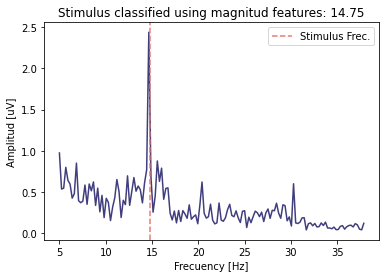

In [8]:
plotOneSpectrum(magnitudCNNClassifier.MSF, resolution, 12, subjects[0], 5, [clasiffication],
              startFrecGraph = FFT_PARAMS['start_frequency'],
              save = False,
              title = f"Stimulus classified using magnitud features: {clasiffication}", folder = "figs")

Podemos ver que el estímulo clasificado por la CNN aparece ubicado exáctamente a donde ocurre la máxima frecuencia del EEG para el trial seleccionado.

### Probando clasificador contra todos los estímulos y con todos los trials

Ahora vamos a usar nuestras CNNs para clasificar todo el set de datos que hemos cargado previamente, esto es, los 3 trials de cada estímulo.

Primero clasificaremos con la CNN que utiliza como features la magnitud de la FFT.

In [9]:
trials = 3
predicciones = np.zeros((len(frecStimulus),trials))

for i, stimulus in enumerate(np.arange(12)):
    for j, trial in enumerate(np.arange(3)):
        data = rawEEG[stimulus,:,:,trial].reshape(1, rawEEG.shape[1],rawEEG.shape[2],1)
        featureVector = magnitudCNNClassifier.getMagnitudFeatureVector(data)
        classification = magnitudCNNClassifier.classifyEEGSignal(featureVector)
        if classification == frecStimulus[stimulus]:
            predicciones[i,j] = 1

predMag = pd.DataFrame(predicciones, index = frecStimulus,
                       columns = [f"trial {trial+1}" for trial in np.arange(trials)])

##### Imprimimos nuestros datos de clasificación

- Un valor de *1.0* indica que la CNN ha clasificado correctamente.
- Un valor de *0.0* indica que la CNN ha clasificado incorrectamente.

In [10]:
print("Predicciones usando como features la magnitud de la FFT")
print( predMag)

Predicciones usando como features la magnitud de la FFT
       trial 1  trial 2  trial 3
9.25       1.0      1.0      1.0
11.25      1.0      1.0      1.0
13.25      1.0      1.0      1.0
9.75       1.0      1.0      1.0
11.75      1.0      1.0      1.0
13.75      1.0      1.0      1.0
10.25      1.0      1.0      1.0
12.25      1.0      1.0      1.0
14.25      1.0      1.0      1.0
10.75      1.0      1.0      1.0
12.75      1.0      1.0      1.0
14.75      1.0      1.0      1.0


##### Clasificaciones usando las features con parte real e imaginaria

Prestar atención que para el caso de clasificar usando el vector de características que contiene la parte real e imaginaria dela FFT debemos usar el objeto *complexCNNClassifier* ya que este ha sido creado a partir de estos vectores de características y por lo tanto debemos alimentarlo **únicamente** con estos tipos de vectores.

In [11]:
predicciones = np.zeros((len(frecStimulus),trials))    
for i, stimulus in enumerate(np.arange(12)):
    for j, trial in enumerate(np.arange(3)):
        data = rawEEG[stimulus,:,:,trial].reshape(1, rawEEG.shape[1],rawEEG.shape[2],1)
        featureVector = magnitudCNNClassifier.getComplexFeatureVector(data)
        classification = complexCNNClassifier.classifyEEGSignal(featureVector)
        if classification == frecStimulus[stimulus]:
            predicciones[i,j] = 1

predCom = pd.DataFrame(predicciones, index = frecStimulus,
                       columns = [f"trial {trial+1}" for trial in np.arange(trials)])

##### Imprimimos nuestros datos de clasificación

- Un valor de *1.0* indica que la CNN ha clasificado correctamente.
- Un valor de *0.0* indica que la CNN ha clasificado incorrectamente.

In [12]:
print("Predicciones usando features con parte real e imaginaria")
print(predCom)

Predicciones usando features con parte real e imaginaria
       trial 1  trial 2  trial 3
9.25       1.0      1.0      1.0
11.25      1.0      1.0      1.0
13.25      1.0      1.0      1.0
9.75       1.0      1.0      1.0
11.75      1.0      1.0      1.0
13.75      1.0      1.0      1.0
10.25      1.0      1.0      1.0
12.25      1.0      1.0      1.0
14.25      1.0      1.0      1.0
10.75      1.0      1.0      1.0
12.75      1.0      1.0      1.0
14.75      1.0      1.0      1.0


## Comentarios finales

En el caso de que quisieramos usar alguna de las CNN entrenadas previamente los pasos que debemos llevar a cabo para clasificar señales de EEG en tiempo real son sencillos.

1) Primero creamos una CNN a partir de un modelo previamente guardados. Esto lo hacemos al crear el objeto **CNNClassify** cuando le pasamos, entre otros parámetros, el nombre del archivo que debe utilizar para crear la CNN con los pesos lamacenados y obtenidos durante el entrenamiento utilizando el módulo **CNNTrainingModule**.
2) En segundo lugar formamos el vector de características utilizando los métodos *computeMSF()* seguido de getDataForClassification